In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import linear_model,svm
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

### Loading the data

In [2]:
from src.load import *

In [3]:
train_X, val_X, train_y, val_y = read_data()

In [4]:
train_X.head()

,ex_id,user_id,prod_id,rating,date,review
0,0,923,0,3.0,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,2010-11-01,Snack is great place for a casual sit down lu...


In [5]:
train_y["label"].value_counts(normalize = True)

0    0.897084
1    0.102916
Name: label, dtype: float64

In [6]:
review = pd.DataFrame(train_X['review'])
review

,review
0,The food at snack is a selection of popular Gr...
1,This little place in Soho is wonderful. I had ...
2,ordered lunch for 15 from Snack last Friday. ...
3,This is a beautiful quaint little restaurant o...
4,Snack is great place for a casual sit down lu...
...,...
250869,Made a reservation for an early dinner Saturda...
250870,"Emily is like Franny's Marco, but with warmth ..."
250871,Can't say enough good things about this place....
250872,"Had a great dinner here- fantastic pizza, the ..."


In [7]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

# summarize class distribution
counter = Counter(train_y)
print(counter)
# # scatter plot of examples by class label
# for label, _ in counter.items():
#     row_ix = where(train_y == label)[0]
#     pyplot.scatter(review[row_ix, 0], review[row_ix, 1], label=str(label))
# pyplot.legend()
# pyplot.show()

Counter({'label': 1})


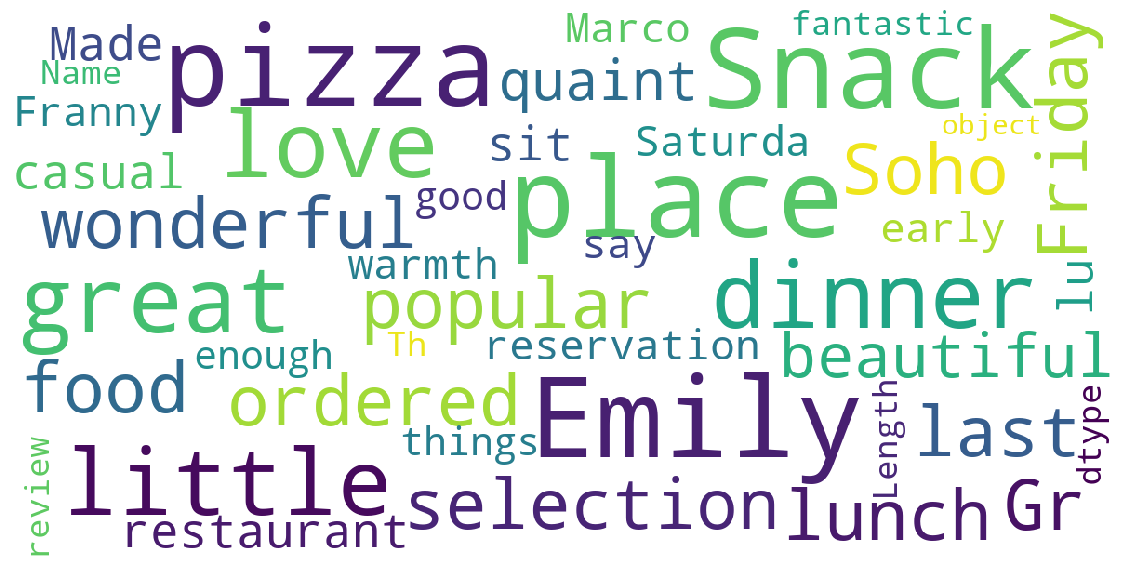

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(train_X["review"])

### Feature Engineering

Cleaning the data

In [ ]:
# from src.clean import *

In [ ]:
# train_X = clean_data(train_X)

### TF-IDF method

In [9]:
from src.tfidf import *

In [ ]:
train_X_tfidf, val_X_tfidf = tfidf(train_X, val_X)

In [ ]:
tfidfvec = TfidfVectorizer(stop_words='english', binary=True)

In [ ]:
text_data = pd.DataFrame(train_X['review'])
text_val = pd.DataFrame(val_X['review'])
# # Add a new column for review length
# train['len(review)'] = train['review'].apply(lambda x: len(x.split()))

# Fit the text data and build a vocabulary
train_tfidf = tfidfvec.fit(text_data.review)
train_X_tfidf = tfidfvec.transform(text_data.review)
val_X_tfidf = tfidfvec.transform(text_val.review)

In [ ]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
train_tfidf.vocabulary_

In [ ]:
columns=tfidfvec.get_feature_names()
columns[-5:-1]

#### Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_RUS, y_RUS = rus.fit_sample(train_X_tfidf, train_y)
pd.DataFrame(X_RUS.todense(), columns=tfidfvec.get_feature_names())

In [ ]:
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = undersample.fit_resample(train_X_tfidf, train_y)

In [ ]:
X_under

#### Oversampling

In [ ]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.1)
# fit and apply the transform
X_over, y_over = over.fit_resample(train_X_tfidf, train_y)
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = undersample.fit_resample(X, y)

### Naive Bayes

In [ ]:
nb = BernoulliNB()

nb_tf = nb.fit(train_X_tfidf, train_y)
Y_nbtf_pred = nb_tf.predict(val_X_tfidf)
Y_nbtf_pred_proba = nb_tf.predict_proba(val_X_tfidf)[::,1]


def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label= lab+' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
plotAUC(val_y, Y_nbtf_pred_proba, 'NB TFIDF')

plt.show()

In [ ]:
nb_under = nb.fit(X_under, y_under)
Y_nbtf_pred = nb_tf.predict(val_X_tfidf)
Y_nbtf_pred_proba = nb_tf.predict_proba(val_X_tfidf)[::,1]
    
plotAUC(val_y, Y_nbtf_pred_proba, 'NB TFIDF')

plt.show()